## PRE-PROCESSING ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
from random import randint
from numpy.random import default_rng
from sklearn.linear_model import LinearRegression

In [2]:
#membuat variabel file_extension
file_extension = ".xlsx"

#Membuat list file dengan extensi .xlsx
stock = [i for i in glob
         (f"*{file_extension}")]

#Melakukan import semua data saham
df = pd.concat((pd.read_excel(file).assign(filename = file)
          for file in stock), axis = 1, ignore_index = False)

#Membersihkan dataframe dari semua kolom yang tidak akan digunakan
df.drop(['Date','Open','High','Low','Adj Close','Volume','filename'], axis=1, inplace=True)

#Menghilangkan baris dengan nilai null
df.dropna(axis=0, inplace=True)

#Merubah semua nama kolom secara berturut-turut
new_col = ['ACES', 'ADRO', 'AKRA', 'ANTM', 'ASII', 
           'BBCA', 'BBNI', 'BBRI', 'BBTN', 'BMRI', 
           'BRPT', 'BSDE', 'CPIN', 'ERAA', 'EXCL', 
           'GGRM', 'HMSP', 'ICBP', 'INCO', 'INDF', 
           'INKP', 'INTP', 'ITMG', 'JPFA', 'JSMR', 
           'KLBF', 'MDKA', 'MEDC', 'MIKA', 'MNCN', 
           'PGAS', 'PTBA', 'PTPP', 'PWON', 'SMGR', 
           'SMRA', 'TBIG', 'TINS', 'TKIM', 'TLKM', 
           'TOWR', 'TPIA', 'UNTR', 'UNVR', 'WIKA', 'JKSE']
df.columns = new_col

#Menghitung Actual Returns
actual_returns = df.pct_change()
actual_returns.dropna(axis=0, inplace=True)

In [3]:
#HITUNG MARKET
actual_returns_market = actual_returns['JKSE']
actual_returns_market = actual_returns_market.values.reshape(-1,1)

#menghitung expected return market
expected_returns_market = actual_returns_market.mean()

#menghitung variance market
variance_market = actual_returns_market.var()

In [4]:
#Mendefinisikan actual return saham
actual_returns.drop(['JKSE'], axis=1, inplace=True)

#Variance Individual Saham
variance = actual_returns.var(ddof=0)
variance = variance.values.reshape(-1, 1)

#Mendefinisikan x dan y
#Mendefinisikan nilai IHSG sebagai x dan me-reshape menjadi array 2D
x = actual_returns_market
#Mendefinisikan seluruh emiten saham sebagai y
y = actual_returns.values

#Memanggil fungsi regresi linear kedalam variabel regressor
regressor = LinearRegression().fit(x, y)

#Menghitung Nilai Beta (slope) 
beta = regressor.coef_
beta_t = np.transpose(beta)

#Menghitung Nilai Alpha (intercept)
alpha = regressor.intercept_
alpha = alpha.reshape(1, 45)
alpha.shape

#Menghitung Variance Error Residual (ver) Saham (=beta_i x variance_market + variance)
ver = np.transpose(beta * variance_market + variance)
ver.shape

#Menggabungkan array nilai beta, alpha, dan variance error residual
akhir = np.concatenate((beta_t, alpha, ver), axis = 0)
akhir.shape

(3, 45)

# # ALGORITMA GENETIKA ADAPTIF

In [11]:
#membuat fungsi representasi kromosom
def chromosome(n) :
    rng = np.random.default_rng()
    gen = rng.choice(akhir, size = n, axis = 1)
    chromosome_value = np.random.rand(n)
    chromosome_value = chromosome_value/sum(chromosome_value)
    chromosome_value=chromosome_value.reshape(1,n)
    chromosome = np.concatenate((gen, chromosome_value), axis = 0)
    return chromosome

#membuat fungsi untuk membangkitkan populasi
def generate_population(n, pop_size):
    population = [chromosome(n) for _ in range(pop_size)]
    return population

#membuat fungsi untuk memilih induk
def select_parent(population) :
    parent = random.sample(population, 2)
    return parent

#membuat fungsi untuk proses single point crossover 
def crossover(p1, p2) :
    x1, x2 = p1, p2
    c1, c2 = x1[3], x2[3]
    #memilih titik potong
    p = randint(1, len(c1)-1)
    #menerapkan crossover
    c1 = np.concatenate((x1[3][:p], x2[3][p:]), axis = 0).reshape(1, n)
    c2 = np.concatenate((x2[3][:p], x1[3][p:]), axis = 0).reshape(1, n)
    x1 = np.delete(x1, 3, axis = 0)
    x1 = np.concatenate((x1, c1), axis = 0)
    x2 = np.delete(x1, 3, axis = 0)
    x2 = np.concatenate((x2, c2), axis = 0)
    return [x1, x2]

#membuat fungsi untuk proses reciprocal exchange mutation
def mutation(mutation_parent):
    child = mutation_parent.copy()
    point = np.random.choice(range(n), 2)
    while (point[0] == point[1]):
        point = np.random.choice(range(n), 2)
    child[3][point[0]] = mutation_parent[3][point[1]]
    child[3][point[1]] = mutation_parent[3][point[0]]
    return [child]

#membuat fungsi repair
def repair(offspring) :
    offspring_repair = list()
    trash = list()
    for i in offspring :
        if sum(i[3]) > 1.0 :
            if sum(i[3][0:n-1]) >= 1.0 :
                if sum(i[3][0:n-2]) >= 1.0 :
                    trash.append(i)
                else :
                    new_gen = 1.0 - sum(i[3][0:n-2])
                    new_gen = new_gen / 2
                    y = np.concatenate((np.delete(i, 3, axis = 0), np.insert(i[3][0:n-2], n-2, (new_gen, new_gen)).reshape(1, n)), axis = 0)
                    offspring_repair.append(y)
            else :
                new_gen = 1.0 - sum(i[3][0:n-1])
                z = np.concatenate((np.delete(i, 3, axis = 0), np.insert(i[3][0:n-1], n-1, new_gen).reshape(1, n)),  axis = 0)
                offspring.append(z)
        else :
            offspring_repair.append(i)
    return offspring_repair

#membuat fungsi untuk menghitung fitness
def fitness(individual) :
        beta_p = (individual[3]*individual[0]) #menghitung beta portofolio
        beta_p = beta_p.sum(axis = 0)
        alpha_p = (individual[3]*individual[1]) #menghitung alpha portofolio
        alpha_p = alpha_p.sum(axis = 0)
        ver_p = (individual[3]*individual[2]) #menghitung variance error residual portofolio
        ver_p = ver_p.sum(axis = 0)  
        
        ERP = alpha_p + beta_p * expected_returns_market #Menghitung keuntungan (Expected return portofolio)
        risk = beta_p * beta_p * variance_market + ver_p #Menghitung Resiko portofolio (risk)
        fitness = (ERP / risk)
        return fitness

#membuat fungsi untuk mekanisme adaptif
def adaptive(favg, favg_old, cr, mr, threshold) :
    if favg - favg_old >= threshold :
        if cr >= 1 :
            cr = cr
            mr = mr
        else :
            cr = cr + 0.1
            mr = mr - 0.1 
    else :
        if cr <= 0 :
            cr = cr
            mr = mr
        else :
            cr = cr - 0.1
            mr = mr + 0.1
    return [cr, mr]

#membuat fungsi untuk proses seleksi (elitism selection)
def Selection(evaluation, pop_size):
    evaluation = sorted(evaluation, key = lambda x: fitness(x),reverse=True)
    percentage_elite_idx = int(pop_size)
    return evaluation[:percentage_elite_idx]

#membuat fungsi algoritma genetika adaptif
def adaptive_genetic_algorithm(n, pop_size, generation, crossover_rate, mutation_rate, threshold) :
    #generate populasi
    population = generate_population(n, pop_size)
    iteration = 0
    while iteration < generation :
        # Inisialisasi parameter yang akan berubah secara adaptif
        cr = crossover_rate     # CrossoverRate awal
        mr = mutation_rate      # MutationRate awal
        favg_old = 0            # favg_old awal
        #Memilih Parent crossover
        offspring = list()
        crossover_offspring = 0
        while crossover_offspring < int(pop_size * cr) :
            crossover_parent = select_parent(population)
            p1, p2 = crossover_parent[0], crossover_parent[1]
            child = crossover(p1, p2)
            offspring.extend(child)
            crossover_offspring = crossover_offspring+2
        mutation_offspring = 0
        while mutation_offspring < int(pop_size * mr) :
            mutation_parent = select_parent(population)
            mutation_child = mutation(mutation_parent[0])
            offspring.extend(mutation_child)
            mutation_offspring = mutation_offspring+1
        #Repair(memperbaiki nilai gen)
        offspring_repair = repair(offspring)
        #evaluation(menggabungkan seluruh induk dan keturunan)
        evaluation = np.concatenate((population, offspring_repair), axis = 0)
        #selection
        selected = Selection(evaluation, pop_size)
        #adaptive schema for next generation
        fit = np.array([fitness(f) for f in evaluation])
        favg = (fit.sum() / len(fit))
        parameter_adaptif = adaptive(favg, favg_old, cr, mr, threshold)
        cr_new, mr_new = parameter_adaptif[0], parameter_adaptif[1]
        cr = cr_new
        mr = mr_new
        favg_old = favg
        population = selected
        iteration = iteration+1
    best = fitness(selected[0])
    return best #individu dengan fitness terbaik diakhir generasi

#Membuat fungsi testing
def testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold):
    x = list()
    iteration = 0
    while iteration < 10 :
        res = adaptive_genetic_algorithm(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
        x.append(res)
        iteration = iteration+1
    x = sum(x) / len(x)
    return x

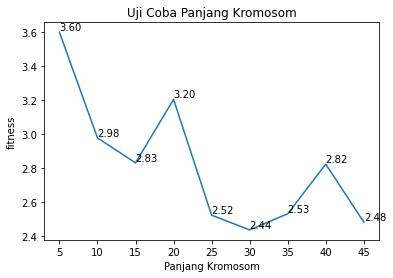

In [65]:
# UJI COBA PANJANG KROMOSOM

#Inisialisasi Parameter
n = 5                 #Panjang Kromosom (sesuai banyak saham)
pop_size = 100        #Jumlah Populasi
generation = 250      #Jumlah Generasi
crossover_rate = 0.5  #crossover_rate
mutation_rate = 0.5   #mutation_rate
threshold = 0.01      #Threshold

chromosome_test_result = list()
test1 = 0
while test1 < 9:
    chromosome_test = testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
    chromosome_test_result.append(chromosome_test)
    n = n+5
    test1 = test1+1
# Visualisasi Hasil
x = [5, 10, 15, 20, 25, 30, 35, 40, 45]
y = np.array(chromosome_test_result).reshape(test1,)
plt.plot(x,y)
plt.xlabel('Panjang Kromosom')
plt.ylabel('fitness')
plt.title('Uji Coba Panjang Kromosom')
for x, y in zip(x, y) :
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords = "offset points", xytext = (0, 2), ha = 'left')

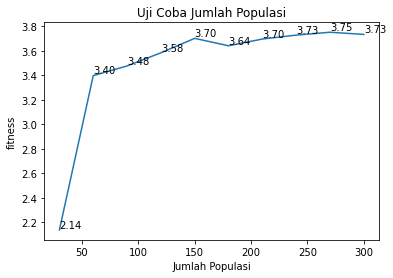

In [71]:
# UJI COBA JUMLAH POPULASI

#Inisialisasi Parameter
n = 5                #Panjang Kromosom (sesuai banyak saham)
pop_size = 20         #Jumlah Populasi
generation = 250      #Jumlah Generasi
crossover_rate = 0.5  #crossover_rate
mutation_rate = 0.5   #mutation_rate
threshold = 0.01     #Threshold

population_test_result = list()
test1 = 0
while test1 < 10:
    population_test = testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
    population_test_result.append(population_test)
    pop_size = pop_size+50
    test1 = test1+1
# Visualisasi Hasil
x = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
y = np.array(population_test_result).reshape(test1,)
plt.plot(x,y)
plt.xlabel('Jumlah Populasi')
plt.ylabel('fitness')
plt.title('Uji Coba Jumlah Populasi')
for x, y in zip(x, y) :
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords = "offset points", xytext = (0, 2), ha = 'left')

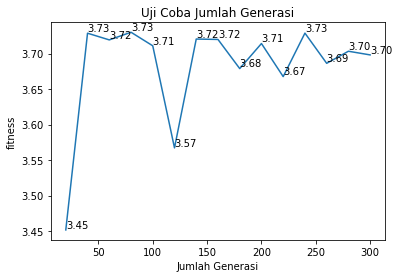

In [49]:
# UJI COBA GENERASI

# Inisialisasi Parameter
n = 5                 #Panjang Kromosom (sesuai banyak saham)
pop_size = 260        #Jumlah Populasi
generation = 20       #Jumlah Generasi
crossover_rate = 0.5  #crossover_rate
mutation_rate = 0.5   #mutation_rate
threshold = 0.01     #Threshold

# Pengujian
generation_test_result = list()
test2 = 0
while test2 < 15:
    generation_test = testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
    generation_test_result.append(generation_test)
    generation = generation+20
    test2 = test2+1
# Visualisasi Hasil
x = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
y = np.array(generation_test_result).reshape(test2,)
plt.plot(x,y)
plt.xlabel('Jumlah Generasi')
plt.ylabel('fitness')
plt.title('Uji Coba Jumlah Generasi')
for x, y in zip(x, y) :
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords = "offset points", xytext = (0, 2), ha = 'left')

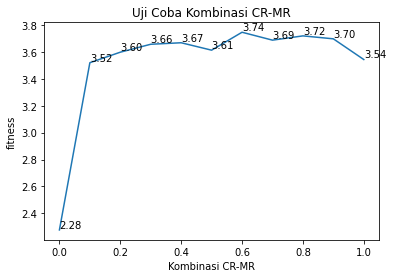

In [53]:
# UJI KOMBINASI NILAI CR-MR

# Inisialisasi Parameter
n = 5                 #Panjang Kromosom (sesuai banyak saham)
pop_size = 260        #Jumlah Populasi
generation = 80      #Jumlah Generasi
crossover_rate = 1.0  #crossover_rate
mutation_rate = 0.0   #mutation_rate
threshold = 0.01     #Threshold

combination_test_result = list()
test3 = 0
while test3 < 11:
    combination_test = testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
    combination_test_result.append(combination_test)
    crossover_rate = crossover_rate - 0.1
    mutation_rate = mutation_rate + 0.1
    test3 = test3+1
# Visualisasi Hasil
x = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
y = np.array(combination_test_result).reshape(11,)
plt.plot(x,y)
plt.xlabel('Kombinasi CR-MR')
plt.ylabel('fitness')
plt.title('Uji Coba Kombinasi CR-MR')
for x, y in zip(x, y) :
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords = "offset points", xytext = (0, 2), ha = 'left')

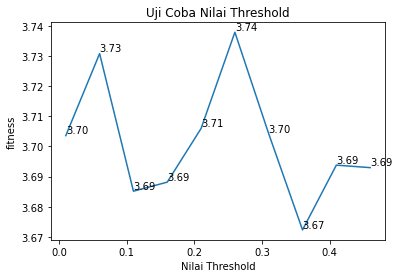

In [57]:
# UJI COBA THRESHOLD

#Inisialisasi Parameter
n = 4                #Panjang Kromosom (sesuai banyak saham)
pop_size = 260         #Jumlah Populasi
generation = 80      #Jumlah Generasi
crossover_rate = 0.6  #crossover_rate
mutation_rate = 0.4   #mutation_rate
threshold = 0.01     #Threshold

threshold_test_result = list()
test4 = 0
while test4 < 10:
    threshold_test = testing(n, pop_size, generation, crossover_rate, mutation_rate, threshold)
    threshold_test_result.append(threshold_test)
    threshold = threshold+0.05
    test4 = test4+1
# Visualisasi Hasil
x = [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46]
y = np.array(threshold_test_result).reshape(test4,)
plt.plot(x,y)
plt.xlabel('Nilai Threshold')
plt.ylabel('fitness')
plt.title('Uji Coba Nilai Threshold')
for x, y in zip(x, y) :
    label = "{:.2f}".format(y)
    plt.annotate(label, (x, y), textcoords = "offset points", xytext = (0, 2), ha = 'left')